<a href="https://colab.research.google.com/github/kaleem500bc/ImageSegmentation/blob/master/Sigmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from matplotlib import pyplot as plt
import numpy as np
from pycocotools.coco import COCO
from skimage import io
from matplotlib import patches
import threading
import queue
from PIL import Image
import urllib
import requests
import os
import copy
import random

In [2]:
#download annotation file
!wget -O annotation.zip http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip annotation.zip

--2020-09-14 11:47:49--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.138.99
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.138.99|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘annotation.zip’

annotation.zip      100%[===================>] 241.16M  46.1MB/s    in 5.7s    

2020-09-14 11:47:55 (42.7 MB/s) - ‘annotation.zip’ saved [252872794/252872794]

Archive:  annotation.zip
  inflating: annotations/instances_train2014.json  
  inflating: annotations/instances_val2014.json  
  inflating: annotations/person_keypoints_train2014.json  
  inflating: annotations/person_keypoints_val2014.json  
  inflating: annotations/captions_train2014.json  
  inflating: annotations/captions_val2014.json  


In [3]:
annfileInstances = "/content/annotations/instances_train2014.json"
coco = COCO(annfileInstances)

loading annotations into memory...
Done (t=11.08s)
creating index...
index created!


In [4]:
#Instances that should be segmented, can be extended/modify , for instance cats = ['cat', 'dog', 'person']
cats = ['person', 'car'] 

imgIds = []

for catNm in cats:
  imgIds.append(coco.getImgIds(catIds=coco.getCatIds(catNms = catNm)))

imgIds.append(coco.getImgIds(catIds=coco.getCatIds(catNms = cats)))

imgIds = [item for l in imgIds for item in l]

#shuffle images ids
random.shuffle(imgIds)

#number of training images is 1000 
trainingImgIds = imgIds[:1000]

In [5]:
#Download dataset on separate thread as the it takes long time, using producer-consumer pattern

downloadQueue = queue.Queue()
imgIdandMask = 0
stop = True


class download(threading.Thread):

  def __init__(self,imgIds):
    super(download,self).__init__()
    self.imgIds = imgIds
    self.setName("producer")
  
  def run(self):
    for id in self.imgIds:
      imgData = coco.loadImgs(id)[0]

      with requests.get(imgData['coco_url'],stream=True).raw as imgDownload:
        img = Image.open(imgDownload)
        item = (img, id)
        downloadQueue.put(item)
    stop = False
    


      
  
class datasetConsumer(threading.Thread):

  def __init__(self):
    super(datasetConsumer,self).__init__()
    self.setName("consumer")

  def run(self):
    global imgId, stop
    if not os.path.exists('/content/cocoSubset'):
      os.mkdir('/content/cocoSubset')
    while stop:
      img,id = downloadQueue.get()
      img.save(("/content/cocoSubset/{}.jpg").format(id))



producer = download(imgIdsPart)
consumer = datasetConsumer()

producer.start()
consumer.start()

In [6]:
#check whether the required threads named "producer" and "consumer" are running
for thread in threading.enumerate():
  print(thread.name)

MainThread
Thread-2
Thread-3
Thread-1
producer
consumer


In [35]:
#custom dataset class
class dataset(torch.utils.data.Dataset):
  
  def __init__(self, root, imgsPath, cats, transform=None):
    self.root = root
    self.imgsList = imgsPath
    self.catsIds = coco.getCatIds(cats)
    self.cats = cats
    self.transform = transform

  def __getitem__(self,imgIdx):
    id = self.imgsList[imgIdx]
    img = Image.open(os.path.join(self.root,"{}.jpg".format(id))).convert('RGB')
    annId = coco.getAnnIds(id,self.catsIds)
    anns = coco.loadAnns(annId)
    mask = 0
    for i_ann in anns:

      testMask = coco.annToMask(i_ann)
      if i_ann['category_id'] == 3:
        testMask *= 2
      if i_ann['category_id'] == 1:
        testMask *= 1

      mask += testMask
      mask = np.where(mask > 2, 2, mask)

    if transform is not None:
      img = self.transform(img)

    return img, mask

  def __len__(self):
    return len(self.imgsList)


In [36]:
root = "/content/cocoSubset"
transform = transforms.Compose([
                                # transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                
])


cocoDataset = dataset(root,trainingImgIds, cats, transform)
BATCHSIZE = 32
cocoDatasetLoader = torch.utils.data.DataLoader(cocoDataset, BATCHSIZE)


In [41]:
#use fcn_resnet101 as the base model
fcn_resnet101 = torchvision.models.segmentation.fcn_resnet101(pretrained=True)
for layer in fcn_resnet101.parameters():
  layer.requires_grad = False


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth


In [42]:
class modifiedfcn_resnet101(nn.Module):
  def __init__(self, fcn_resnet101, numClasses):
    super().__init__()
    self.fcn_resnet101 = fcn_resnet101
    in_channels = fcn_resnet101.classifier[0].in_channels
    classifier = nn.Sequential(
                nn.Conv2d(in_channels,512,kernel_size=(3,3)),
                nn.ReLU(),
                nn.Conv2d(512, numClasses,kernel_size=(1,1))
            )
    self.fcn_resnet101.classifier = classifier

  def forward(self, x):
    x= self.fcn_resnet101(x)
    return x['out']

#number of classes that should be segmented
numCls = len(cats)+1 # +1 is the background
model = modifiedfcn_resnet101(fcn_resnet101, numCls)


In [ ]:
optim = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [63]:
model.to("cuda")

def training(epochs, model, optimizer, criterion):

  for e in range(epochs):
    print("Epoch: "+str(e+1))
    totalLoss = []
    eloss = 0
    for img, label in cocoDataset:
      
      #input to the network is minibatch x channel(s) x W x H
      img = img.unsqueeze(0)

      #target should be minibatch x W x H
      label = torch.tensor(label, dtype=torch.long)
      label = label.unsqueeze(0)
      
      img, label = img.to("cuda"), label.to("cuda")

      #output of the network will be minibatch x classes x W x H: here clasess are background and person
      out = model(img)

      optimizer.zero_grad()

      loss = criterion(out,label)

      loss.backward()

      optimizer.step()

      eloss += loss.item()

    
    print('loss per epoch '+str(eloss))
    totalLoss.append(eloss)
  
  return totalLoss

  

In [64]:
epochs = 5
epochList = list(range(5))
lossArray = training(epochs, model, optim, criterion)

Epoch: 1
loss per epoch 401.83825257467106
Epoch: 2
loss per epoch 164.24273037002422
Epoch: 3
loss per epoch 199.60388697078452
Epoch: 4
loss per epoch 184.6651445776224
Epoch: 5
loss per epoch 167.73515347763896


In [ ]:
plt.plot(epochList, lossArray)

In [71]:
#Test Image
imgUrl = 'https://www.autobuzzer.net/wp-content/uploads/2013/03/tips-to-bby-a-new-car.jpg'
testImg = requests.get(imgUrl, stream=True).raw
testImg = Image.open(testImg)
inpt = transform(testImg).unsqueeze(0).to("cuda")
print(inpt.shape)

torch.Size([1, 3, 390, 600])


In [72]:
model.eval()
out1 = model(inpt)
out = out1.squeeze(0)
out = out.argmax(0)

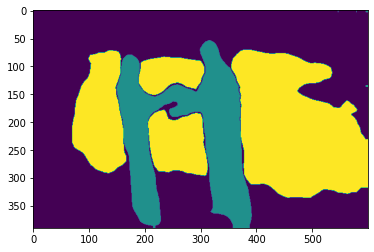

In [73]:
plt.imshow(out.to("cpu").detach().numpy())